# Deep Leaning For Medical Imaging Competition: Lymphocytosis classification

David Faget Caño, Biel Castaño Segade

ENS Paris-Saclay,

 MVA Master's

 March 2024


## Install and import packages

Let's install the needed packages.

In [ ]:
!pip install -q kaggle
!pip install wandb -qU
!pip install pytorch_msssim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

Gather imports in the next cell.

In [ ]:
from google.colab import drive
import os
import h5py
import cv2
from PIL import Image
import pandas as pd
from skimage import io
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import gc
import wandb
import tqdm

Mount Google Drive to access files stored in it directly from this notebook. In particular, we use drive to store the Kaggle API token file (kaggle.json) that we will need to download the competition data.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Login in wandb to monitor experiments.

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Define device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Seed everything for reproducibility

In [ ]:
seed=17

np.random.seed(seed)
torch.manual_seed(seed)

## Download Data and Define Dataset



Configure Kaggle API access (kaggle.json), download the "DLMI Lymphocytosis Classification" competition dataset, and extract it.

In [ ]:
# Copy the kaggle.json file from Google Drive into a new .kaggle directory
# (this is needed to access the competition data, since it is private).
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the competition data
!kaggle competitions download -c dlmi-lymphocytosis-classification -p /content/

# Unzip data to the current directory
%cd /content
!unzip /content/dlmi-lymphocytosis-classification.zip -d /content/data

# Declare path variables
path_data =  '/content/data'
path_file = '/content/'
path_models = "/content/drive/MyDrive/dlmi_competition_models"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/data/trainset/P27/000009.jpg  
  inflating: /content/data/trainset/P27/000010.jpg  
  inflating: /content/data/trainset/P27/000011.jpg  
  inflating: /content/data/trainset/P27/000012.jpg  
  inflating: /content/data/trainset/P27/000013.jpg  
  inflating: /content/data/trainset/P27/000014.jpg  
  inflating: /content/data/trainset/P27/000015.jpg  
  inflating: /content/data/trainset/P27/000016.jpg  
  inflating: /content/data/trainset/P27/000017.jpg  
  inflating: /content/data/trainset/P27/000018.jpg  
  inflating: /content/data/trainset/P27/000019.jpg  
  inflating: /content/data/trainset/P27/000020.jpg  
  inflating: /content/data/trainset/P27/000021.jpg  
  inflating: /content/data/trainset/P27/000022.jpg  
  inflating: /content/data/trainset/P27/000023.jpg  
  inflating: /content/data/trainset/P27/000024.jpg  
  inflating: /content/data/trainset/P27/000025.jpg  
  inflating: /content/data/trainset/P2

Declare a custom torch dataset class, *LymphocytosisDataset*, to effectively load and process the data.

The class admits an optional transform to be applied on the images of a sample (this could be used for data augmentation or preprocessing), and it efficiently manages the loading of all images for each patient into a list of images, and includes relevant clinical information as part of each sample (the lymph count, the age, and the gender).

In [ ]:
class LymphocytosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, mode='train', transform=None):

        self.img_labels = pd.read_csv(annotations_file)

        if mode == 'train':
            self.img_labels = self.img_labels[self.img_labels['LABEL'] != -1]
        elif mode == 'test':
            self.img_labels = self.img_labels[self.img_labels['LABEL'] == -1]

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def calculate_age(self, born_date):
        # Method to compute the age of a person given its born date.
        today = date.today()
        born_date = str(born_date)

        try:
            [day, month, year] = [int(i) for i in born_date.split("/")]
        except ValueError:
            [day, month, year] = [int(i) for i in born_date.split("-")]

        return today.year - year - ((today.month, today.day) < (month, day))

    def __getitem__(self, idx):
        patient_info = self.img_labels.iloc[idx]
        patient_folder = os.path.join(self.img_dir, patient_info['ID'])
        patient_images = [os.path.join(patient_folder, img) for img in os.listdir(patient_folder)]

        # Preprocess images
        images = []
        for img_path in patient_images:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images.append(image)
        images_tensor = torch.stack(images)

        # Read annotations
        id = patient_info['ID']
        label = patient_info['LABEL']
        age = self.calculate_age(patient_info["DOB"])
        gender = 0 if patient_info["GENDER"] == 'M' else 1
        lymph_count = patient_info["LYMPH_COUNT"]

        # Return a dict
        sample = {'id':id,'images': images_tensor, 'label': label, 'gender': gender,
                  'age': age, 'lymph_count': lymph_count}

        return sample

Declare a function to apply a custom preprocess to every image. The preprocessing will consist of obtaining a mask by applying a binary threshold on the images based on the value of the saturation channel in HSV space. This is because we have found lymphocytes are more saturated than the background. Using the mask, only the lymphocytes will appear on the image, the rest being black.

In [ ]:
class CustomPreprocess:
    def __call__(self, img):
        # Convert to HSV and select the saturation component
        img_hsv = img.convert('HSV')
        np_img = np.array(img_hsv)[:, :, 1]

        # Thresholding to get binary image
        _, binary_img = cv2.threshold(np_img, 70, 255, cv2.THRESH_BINARY)
        binary_img_pil = Image.fromarray(binary_img.astype(np.uint8))

        # Convert binary image to RGB to perform element-wise multiplication
        binary_img_rgb = binary_img_pil.convert('RGB')

        # Element-wise multiplication between the original RGB image and the binary mask
        np_img_rgb = np.array(img)
        np_binary_img_rgb = np.array(binary_img_rgb)

        # Normalize to [0,1]
        segmented_img = np_img_rgb * (np_binary_img_rgb / 255)

        # Convert the segmented numpy array back to PIL Image
        segmented_img_pil = Image.fromarray(segmented_img.astype(np.uint8))

        return segmented_img_pil

Let's define the test and train dataset (without splitting it into train and validation, that will be done later).

In [ ]:

# Define the transform pipeline including the custom preprocess, crop, and resize operations
transform_pipeline = transforms.Compose([
    #CustomPreprocess(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Apply the updated preprocessing pipeline to your datasets
train_dataset = LymphocytosisDataset(annotations_file=path_data+'/clinical_annotation.csv',
                                     img_dir=path_data+'/trainset',
                                     transform=transform_pipeline)

test_dataset = LymphocytosisDataset(annotations_file=path_data+'/clinical_annotation.csv',
                                    img_dir=path_data+'/testset',
                                    mode='test',
                                    transform=transform_pipeline)


## Data Analysis and Visualization

To visualize data, let's first plot some examples of annotations from different samples in the training set.

In [ ]:
for i in range(5):
  print(f"Example {i} of annotations in the training set -- Number of images: {len(train_dataset[i]['images'])}, Gender: {'F' if train_dataset[i]['gender'] == 0 else 'M' }, Lymph count: {train_dataset[i]['lymph_count']}, Age: {train_dataset[i]['age']}, Label: {train_dataset[i]['label']}")

Example 0 of annotations in the training set -- Number of images: 100, Gender: F, Lymph count: 11.2, Age: 91, Label: 1
Example 1 of annotations in the training set -- Number of images: 63, Gender: F, Lymph count: 12.8, Age: 81, Label: 1
Example 2 of annotations in the training set -- Number of images: 52, Gender: F, Lymph count: 9.6, Age: 88, Label: 1
Example 3 of annotations in the training set -- Number of images: 173, Gender: F, Lymph count: 122.6, Age: 92, Label: 1
Example 4 of annotations in the training set -- Number of images: 56, Gender: M, Lymph count: 11.6, Age: 92, Label: 1


Now, let's visualize some image examples for the first patient.

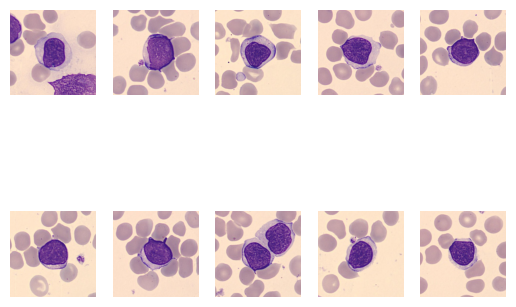

In [ ]:
for i in range(10):

    image = train_dataset[3]['images'][i, :, :, :]
    image = image.numpy().transpose(1, 2, 0)

    # Plot in a 2x5 grid
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

Now, let's plot histograms to analyze the distribution of annotations in the data. The following cell defines a function for this purpose and creates a dataframe containing the values of the train dataset.

In [ ]:
def plot_histogram(values, axs, title, x_labels, y_label, bins, x_ticks=None):
    axs.hist(values, bins=bins, color='blue', alpha=0.7, rwidth=0.85)
    axs.set_title(title)
    if x_ticks is not None:
        axs.set_xticks(x_ticks)
        axs.set_xticklabels(x_labels)
    else:
        axs.set_xlabel(x_labels)
    axs.set_ylabel(y_label)

# Create a DataFrame
df = pd.DataFrame({
    'ID': [sample["id"] for sample in train_dataset],
    'Gender': [sample["gender"] for sample in train_dataset],
    'Label': [sample["label"] for sample in train_dataset],
    'LymphCount': [sample["lymph_count"] for sample in train_dataset],
    'Age': [sample["age"] for sample in train_dataset]
})

Plot the histograms for gender, age and label.

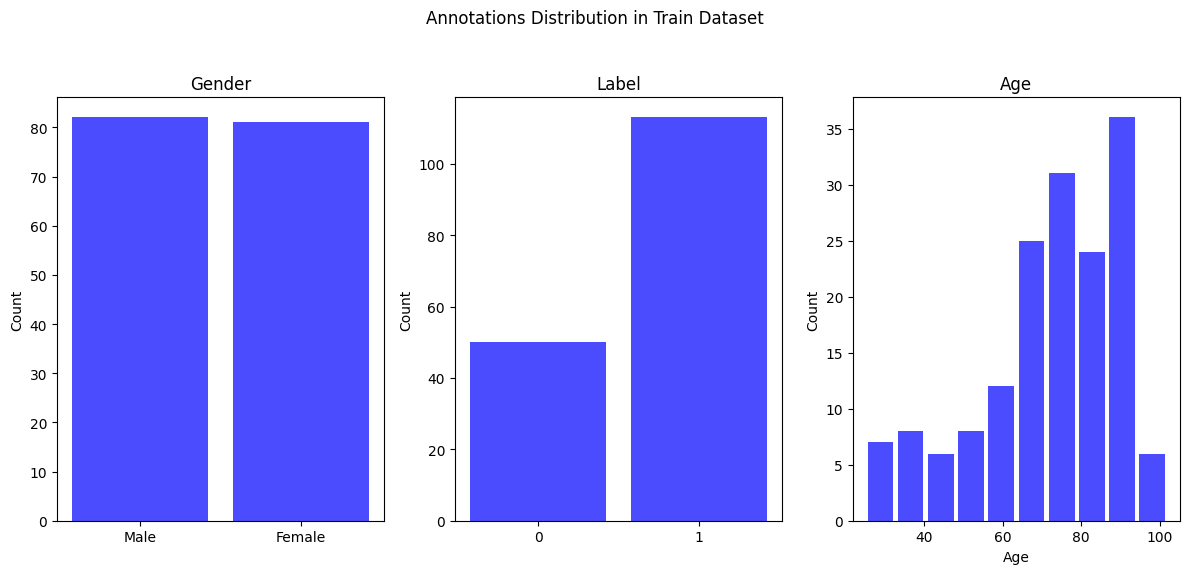

In [ ]:
# Create a 1x3 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
fig.suptitle('Annotations Distribution in Train Dataset')

# Plot histograms
plot_histogram(df['Gender'], axs[0], 'Gender',
               ['Male', 'Female'], 'Count', [-0.5, 0.5, 1.5], [0, 1])
plot_histogram(df['Label'], axs[1], 'Label',
               ['0', '1'], 'Count', [-0.5, 0.5, 1.5], [0, 1])
plot_histogram(df['Age'], axs[2], 'Age',
               'Age', 'Count', 10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

From the graphics, it's evident that the gender distribution is balanced. However, there is approximately twice the number of samples for label '1' compared to label '0'. Additionally, the age distribution is skewed towards older individuals.

Next, we will examine the correlation among the various annotation variables

<ipython-input-15-99c9cdf2d19f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr(method='pearson')


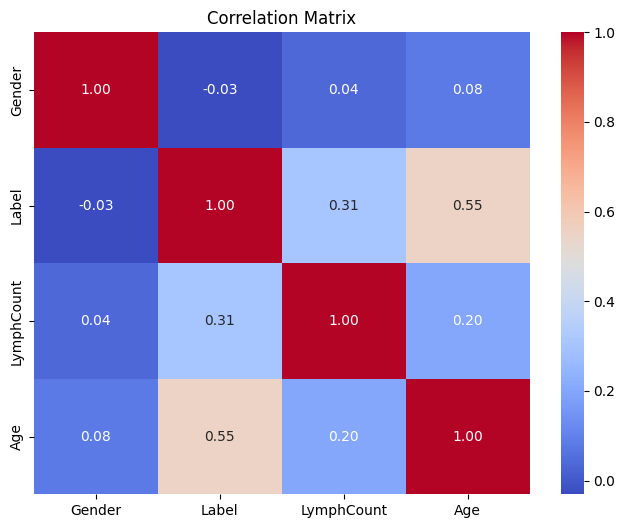

In [ ]:
# Calculate correlation matrix
correlation_matrix = df.corr(method='pearson')

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


The observed correlation between age and label highlights a potentially significant pattern in labels. For example, if younger individuals consistently have label '0' and older individuals predominantly have label '1', this could significantly influence our model interpretation.

To further explore this aspect, next cell will examine the distribution of ages within each label category using a boxplot.

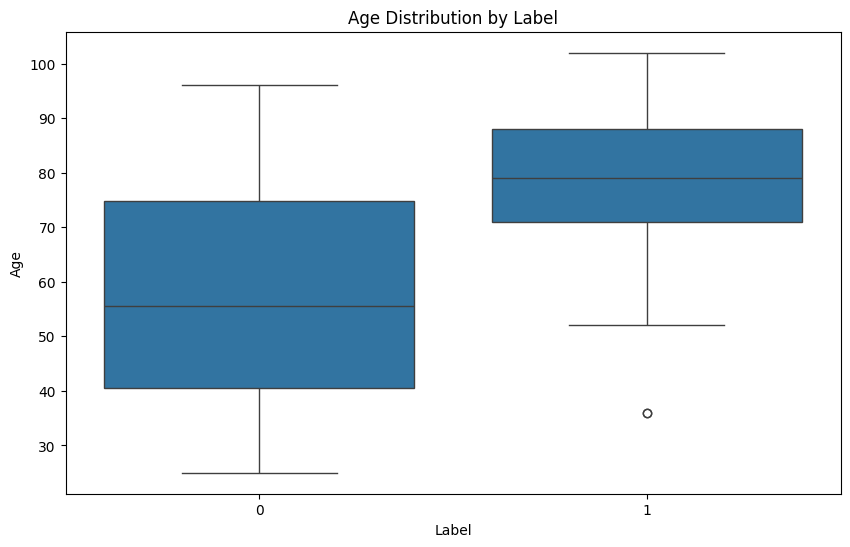

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Age', data=df)
plt.title('Age Distribution by Label')
plt.show()

Since the boxplot analysis shows distinct age distributions for the two labels, it's clear that age has a significant relationship with the label. Notably, individuals under 50 are less likely to have label '1' (with a few outlier exceptions).

Given this significant influence of age on label distribution, a combined stratification approach that considers both age and label would be advantageous for splitting the training dataset into training and validation subsets, instead of just stratifying by label.

## Split Training dataset and Declare Dataloaders

First, let's split the training set into training and validation subsets, using a combined stratification approach that considers both age and label (because of the outcome of the data analysis). The splitting proportion will be 80% - 20%.

Next cell decides how stratification will be done.

In [ ]:
# Discretize age into different bins for stratification
# We put 0-50 in the same class because in 0-25 we do not have enough labels for stratification.
# We need to extend the last class to 105 because there is a patient 102y.o.
df['age_group'] = pd.cut(df['Age'], bins=[0, 50, 75, 105], labels=['0-50', '51-75', '76-105'])

# Create a combined stratification key
df['strat'] = df['age_group'].astype(str) + "_" + df['Label'].astype(str)
print(df['strat'].value_counts())

76-105_1    68
51-75_1     43
0-50_0      19
51-75_0     19
76-105_0    12
0-50_1       2
Name: strat, dtype: int64


Next cell gets the ids for splitting the original dataset into training and validation sub-datasets.

In [ ]:
# Split the dataset
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['strat'], random_state=seed)

# We keep only the id's of train_df and val_df and we filter train_dataset by these id's
train_ids = set(train_df['ID'])
val_ids = set(val_df['ID'])

The class FilteredDataset will be used to filter an original dataset by the given ids.

In [ ]:
class FilteredDataset(Dataset):
    def __init__(self, original_dataset, valid_ids):
        self.original_dataset = original_dataset
        self.valid_ids = valid_ids
        # Filter the indices of the original dataset to keep only those with IDs in valid_ids
        self.filtered_indices = [i for i, sample in enumerate(self.original_dataset) if sample['id'] in self.valid_ids]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        # Map the filtered index back to the original dataset's index
        original_idx = self.filtered_indices[idx]
        return self.original_dataset[original_idx]

Filter the original dataset.

In [ ]:
train_dataset_strat = FilteredDataset(train_dataset, train_ids)
val_dataset_strat = FilteredDataset(train_dataset, val_ids)

Before creating the dataloaders, let's declare a custom collation function to define how a batch is created. This is needed because the sequence of images associated to each sample can have different lengths, causing an error when stacking the tensors in the batch if not handled properly.

In our function, we simply pad the image sequences to match the longest sequence (in the same batch). If batch size is 1, this function doesn't affect performance.


In [ ]:
def custom_collate_fn(batch):

    # Find the sample with the largest sequence of images
    max_length = max(len(item['images']) for item in batch)

    # Initialize new variables to store the batch data
    batch_images = []
    batch_labels = []
    batch_genders = []
    batch_ages = []
    batch_lymph_counts = []

    # Iterate through each sample
    for sample in batch:
        images = sample['images']
        num_images = len(images)

        # Calculate the padding needed to match the largest sequence of images
        padding = max_length - num_images
        padded_images = torch.nn.functional.pad(images, (0, 0, 0, 0, 0, 0, 0, padding), "constant", 0)

        # Store the padded images and the rest of the data
        batch_images.append(padded_images)
        batch_labels.append(sample['label'])
        batch_genders.append(sample['gender'])
        batch_ages.append(sample['age'])
        batch_lymph_counts.append(sample['lymph_count'])

    # Stack padded images
    batch_images = torch.stack(batch_images)

    return {'images': batch_images, 'label': torch.tensor(batch_labels),
            'gender': torch.tensor(batch_genders), 'age': torch.tensor(batch_ages),
            'lymph_count': torch.tensor(batch_lymph_counts)}


Declare the dataloaders.

In [ ]:
batch_size = 1

# Declare dataloaders
train_loader = DataLoader(train_dataset_strat, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset_strat, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

## Define training function

First, define which metrics will be logged for validation.

In [ ]:
def compute_metrics(targets, predictions):
    '''Compute accuracy, sensitivity, specificity, and balanced accuracy'''
    accuracy = accuracy_score(targets, predictions)
    bal_acc = balanced_accuracy_score(targets, predictions)
    tn, fp, fn, tp = confusion_matrix(targets, predictions).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return accuracy, sensitivity, specificity, bal_acc


Next cell defines the training of the model.

In [ ]:

def train(model, loss_fcn, device, optimizer, max_epochs, experiment_name, train_dataloader, val_dataloader, scheduler=None, path_models=path_models):

    best_val_bal_acc = 0.0  # Initialize the best validation balanced accuracy

    # Initialise a wandb run
    wandb.init(project="dlmi", name=f"{experiment_name}", config={})

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        train_targets, train_predictions = [], []

        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()

            # Unpack batch
            images = train_batch['images'].to(device)
            metadata = torch.stack((train_batch['gender'], train_batch['age'], train_batch['lymph_count']), dim=1).float().to(device)
            labels = train_batch['label'].unsqueeze(1).to(device)

            # Forward step
            outputs = model(images, metadata)

            # Compute the loss
            loss = loss_fcn(outputs, labels.float())

            # Metric calculation
            running_loss += loss.item()
            preds = outputs.detach().cpu().numpy()
            train_predictions.extend([pred >= 0.5 for pred in preds])
            train_targets.extend(train_batch['label'].tolist())

            # Optimizer step
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            # Clear memory
            del loss, outputs
            torch.cuda.empty_cache()
            gc.collect()

        # Compute train metrics
        train_accuracy, train_sensitivity, train_specificity, train_bal_acc = compute_metrics(train_targets, train_predictions)
        print(f'Epoch [{epoch+1}/{max_epochs}], Train Loss: {running_loss/len(train_dataloader)}, Train Accuracy: {train_accuracy}, Train Sensitivity: {train_sensitivity}, Train Specificity: {train_specificity}, Train Balanced Acc: {train_bal_acc}')

        # Evaluation on validation set
        model.eval()
        val_loss = 0.0
        val_targets, val_predictions = [], []

        with torch.no_grad():
            for val_batch in val_dataloader:

                # Unpack batch
                images = val_batch['images'].to(device)
                metadata = torch.stack((val_batch['gender'], val_batch['age'], val_batch['lymph_count']), dim=1).float().to(device)
                labels = val_batch['label'].unsqueeze(1).to(device)

                # Forward step
                outputs = model(images, metadata)

                # Compute the loss
                loss = loss_fcn(outputs, labels.float())

                # Metric calculation
                val_loss += loss.item()
                preds = outputs.detach().cpu().numpy()
                val_predictions.extend([pred >= 0.5 for pred in preds])
                val_targets.extend(val_batch['label'].tolist())

        # Compute validation metrics
        val_accuracy, val_sensitivity, val_specificity, val_bal_acc = compute_metrics(val_targets, val_predictions)
        print(f'Epoch [{epoch+1}/{max_epochs}], Validation Loss: {val_loss/len(val_dataloader)}, Validation Accuracy: {val_accuracy}, Validation Sensitivity: {val_sensitivity}, Validation Specificity: {val_specificity}, Validation Balanced Acc: {val_bal_acc}')

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": running_loss/len(train_dataloader),
            "train_accuracy": train_accuracy,
            "train_sensitivity": train_sensitivity,
            "train_specificity": train_specificity,
            "train_balanced_accuracy": train_bal_acc,
            "val_loss": val_loss/len(val_dataloader),
            "val_accuracy": val_accuracy,
            "val_sensitivity": val_sensitivity,
            "val_specificity": val_specificity,
            "val_balanced_accuracy": val_bal_acc,
        })

        # Check if this is the best accuracy so far and save if it is
        if val_bal_acc > best_val_bal_acc:
            best_val_bal_acc = val_bal_acc
            torch.save(model.state_dict(), os.path.join(path_models, f'{experiment_name}_best_accuracy_checkpoint.pt'))

    wandb.finish()

## Model training

Define the model in the next cell, based in the combination of a MLP to preprocess metadata (clinic data) and a CNN to extract features of the images, that will be aggregated using different functions (mean or a basic form of attention). After the image aggregation and the metadata processing, the final classifier will be a linear layer.

In [ ]:
# A basic form of attention (much more basic than the one presented in transformers)
class AttentionModule(nn.Module):
    def __init__(self, in_features, hidden_dim=64):
        super(AttentionModule, self).__init__()
        self.attention_layer = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        weights = self.attention_layer(x)
        weighted_features = torch.mul(x, weights)
        aggregated_features = torch.sum(weighted_features, dim=1)
        return aggregated_features

# image attention based on transformers, discarded because of very bad results
'''class ImageAttention(nn.Module):
    def __init__(self, in_features):
        super(ImageAttention, self).__init__()
        self.attention_vector_size = 512
        self.key = nn.Linear(in_features, self.attention_vector_size)
        self.query = nn.Linear(in_features, self.attention_vector_size)
        self.value = nn.Linear(in_features, in_features)

    def forward(self, x):
        batch_size, num_images, _ = x.shape

        # Compute Q, K, V
        Q = self.query(x)  # (batch_size, num_images, attention_vector_size)
        K = self.key(x)    # (batch_size, num_images, attention_vector_size)
        V = self.value(x)  # (batch_size, num_images, attention_vector_size)

        # Attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.attention_vector_size**0.5
        attention_probs = F.softmax(attention_scores, dim=-1)

        # Apply attention scores as weights for V
        weighted_sum = torch.matmul(attention_scores, V)

        # Aggregate across num_images dimension
        aggregated_features = weighted_sum.sum(dim=1)  # (batch_size, in_features)

        return aggregated_features'''

# Classification model (multiple instance learning)
class MilModel(nn.Module):
    def __init__(self):
        super(MilModel, self).__init__()
        # Use a pre-trained model as a feature extractor
        self.feature_extractor = models.resnet34(pretrained=True)
        self.feature_extractor.fc = nn.Identity()  # Remove the last FC layer

        # Attention module for image features
        self.attention_module = AttentionModule(in_features=512)  # ResNet feature size

        # Additional layers for patient metadata processing
        self.metadata_processor = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # Final classifier
        self.classifier = nn.Linear(64 + 512, 1)

    def forward(self, images, metadata):
        # Process images
        batch_size = len(images)
        img_features_list = []
        for i in range(batch_size):
            img_features = self.feature_extractor(images[i])  # Process each image
            img_features_list.append(img_features.unsqueeze(0))
        img_features = torch.cat(img_features_list, dim=0)

        # Aggregate features with attention
        img_features = self.attention_module(img_features)  # Apply attention mechanism

        # Process metadata
        metadata_features = self.metadata_processor(metadata)

        # Concatenate features
        combined_features = torch.cat((img_features, metadata_features), dim=1)

        # Classify
        out = self.classifier(combined_features)
        return torch.sigmoid(out)  # Use sigmoid to output a probability

Declare the hyperparameters and train the model.

In [ ]:
model = MilModel().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
max_epochs = 50
criterion = F.binary_cross_entropy

train(model, criterion, device, optimizer, max_epochs,
          "metadata_BRANCH_lr_0.001_optimizer_ADAM_aggregation_ATTENTION_NOPREPROCESS", train_loader, val_loader, scheduler=scheduler)

## Submission

For submitting the model results on the test dataset, let's prepare a data frame for the dataset.

In [ ]:
df_test = pd.DataFrame({
    'ID': [sample["id"] for sample in test_dataset],
    'Gender': [sample["gender"] for sample in test_dataset],
    'LymphCount': [sample["lymph_count"] for sample in test_dataset],
    'Age': [sample["age"] for sample in test_dataset]
})

Next cell creates a .csv file containing the model predictions for the test dataset.

In [ ]:
sub_dict = {"ID":[], "Predicted": []}
model.eval()

for idx, train_batch in enumerate(test_loader):
    # Move data to device
    images = train_batch['images'].to(device)
    metadata = torch.stack((train_batch['gender'], train_batch['age'], train_batch['lymph_count']), dim=1).float().to(device)

    # Forward pass
    outputs = model(images, metadata)

    # Apply threshold
    batch_predictions = (outputs >= 0.5).int()

    # Save results
    sub_dict["ID"].append(df_test.iloc[idx,0])
    sub_dict['Predicted'].append(int(batch_predictions.cpu().numpy()))

df_sub = pd.DataFrame.from_dict(sub_dict)

# Save csv
df_sub.to_csv('submission.csv', index=False)

<ipython-input-27-2b506cb26731>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sub_dict['Predicted'].append(int(batch_predictions.cpu().numpy()))
